In [1]:
import os
import sys
import numpy as np
import pandas as pd
import math
import datetime
import h5py
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.dates as dates
from scipy.interpolate import interp2d
from scipy.signal import medfilt2d
from scipy.ndimage import median_filter
from model_utils import *
from scipy.ndimage import median_filter
import matplotlib.dates as dates
########################################################################
### Notebook que calcula el promedio mensual de las derivas verticales 
### de un mes determinado y lo compara con las predicciones del modelo
### de Scherliess-Fejer.
### Requiere que los datos de Madrigal se encuentren en un directorio 
### como el siguiente: ./Data-Noviembre-2023
########################################################################

### Funciones utilizadas en el notebook:

In [2]:
def SumArrays(a,b):
#################################################
### Función para sumar arreglos que contienen 
### valores NaN.
### Inputs:
###       float, array-1D - a,b
### Output:
###       float, array-1D, c
#################################################
    fils,cols = a.shape
    c = np.ones((fils,cols))*np.nan
    for i in range(fils):
        for j in range(cols):
            if np.isnan(a[i,j]):
                if np.isnan(b[i,j]):
                    c[i,j]=np.nan
                else:
                    c[i,j] = b[i,j]
            else: 
                if np.isnan(b[i,j]):
                    c[i,j] =  a[i,j]
                else:
                    c[i,j] = a[i,j] + b[i,j]
    return c
###################################################
def GetDate(year,doy):
############################################
### Función que obtiene el mes y el día del
### año y día del año.
### Inputs:
###       int - year,
###       int - doy,
### Outputs:
###       int - month,
###       int - day.
###########################################
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    month = d.month
    day = d.day
    return month, day
#######################################################################
def ShowArrays(directory, filename, PlotFlag):
#######################################################################
### Función que grafica RTIs.
### Inputs:
###       str - directory
###       str - filename
###       bool - PlotFlag
### Outputs:
###       float, array-1D    - range_array,
###       datetime, array-1D - datetime_objects,
###       float, array-2D    - v_vertical
#######################################################################
    file_hf5 = directory + os.sep +filename
    hf = h5py.File(file_hf5, 'r')
    rango = hf['Data/Table Layout/']['gdalt']
    timestamps = hf['Data/Array Layout/']['timestamps']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn']
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)
    delta_range = np.diff(rango)[0]
    range2D = rango.reshape(v_vertical.T.shape)
    MinRange, MaxRange = np.min(rango), np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = range2D[0]
    datetime_objects = np.array([datetime.datetime.fromtimestamp(ts) for ts in timestamps])
    year  = datetime_objects[0].year
    month = datetime_objects[0].month
    day   = datetime_objects[0].day 
    str_month = GetMonth(month)
    dir_plots = 'Plots-%s-%d' % (str_month, year)
    plot_format = 'png'
    v_vertical = RemoveIQR(v_vertical)
    v_vertical[v_vertical<-45] = np.nan
    v_vertical[v_vertical> 45] = np.nan
    if PlotFlag:
        fig, ax = plt.subplots(figsize=(12, 6))
        clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, v_vertical, cmap=plt.cm.RdBu_r)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim(300,400)
        fig_title = r'Derivas Verticales ISR (%d-%02d-%02d)' % (year, month, day)
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (year, month, day)
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        cb.set_label(r'Derivas verticales (m/s)')
        plt.savefig(r'%s/Drifts-ISR-%d-%02d-%02d-v-vertical.%s' % (dir_plots,year, month, day, plot_format),bbox_inches='tight')
        plt.show()
        plt.close(fig)
        
    return range_array,datetime_objects,v_vertical
###########################################################################################
def interp_mat(A):
##########################################
### Función que interpola una matriz 2D.
### Input: 
###      float, array-2D - A
### Output:
###      float, array-2D - A
##########################################
    A = v_vertical.copy()
    ok = ~np.isnan(A)
    xp = ok.ravel().nonzero()[0]
    fp = A[~np.isnan(A)]
    x  = np.isnan(A).ravel().nonzero()[0]
    A[np.isnan(A)] = np.interp(x, xp, fp)
    return A
###############################################################################################
def getRangeIndices(h_min, h_max, range_array):
###################################################################
### Función que recibe un arreglo de alturas y un rango de alturas.
### Retorna los índices del rango de alturas.
### Inputs:
###       float           - h_min, h_max
###       float, array-1D - range_array
###################################################################
    min_ind = list(np.abs(h_min-range_array)).index(min(np.abs(h_min-range_array)))
    max_ind = list(np.abs(h_max-range_array)).index(min(np.abs(h_max-range_array)))
    return min_ind, max_ind
##############################################################################################
def GetMatrix(directory, filename, PlotFlag, plot_format):
#######################################################################
### Función que grafica RTIs.
### Inputs:
###       str - directory
###       str - filename
###       bool - PlotFlag
### Outputs:
###       float, array-1D    - range_array,
###       datetime, array-1D - datetime_objects,
###       float, array-2D    - v_vertical
#######################################################################
    file_hf5 = directory + os.sep +filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    rango = hf['Data/Table Layout/']['gdalt']
    timestamps = hf['Data/Array Layout/']['timestamps']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn']
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max, ran_min = max(rango), min(rango)
    max_index, min_index = rango.index(ran_max),rango.index(ran_min)
    range_diff = np.diff(rango)
    delta_range = range_diff[0]
    delta_ran = delta_range
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range) + 1
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows)
    datetime_objects = np.array([datetime.datetime.fromtimestamp(ts) for ts in timestamps])
    index = datetime_objects
    h_min_aux=300
    h_max_aux=400
    min_ind_aux, max_ind_aux = getRangeIndices(h_min_aux, h_max_aux, range_array)
    v_zonal_avg = np.nanmean(v_zonal[:,min_ind_aux:max_ind_aux],axis=1)
    v_zonal_std = np.nanstd(v_zonal[:,min_ind_aux:max_ind_aux],axis=1)
    vvert_interp = interp_mat(v_vertical)
    mes = datetime_objects[0].month
    month_str = GetMonth(mes)
    dia = datetime_objects[0].day
    anio = datetime_objects[0].year
    v_vertical[v_vertical<-25] = np.nan
    v_vertical[v_vertical>25] = np.nan
    p95, p5 = np.percentile(v_vertical, [95, 5])
    dir_plots = 'Plots-%s-%d' % (month_str, anio)
    print(dir_plots)
    df_zonal = pd.DataFrame({'vz':v_zonal_avg,'std_vz':v_zonal_std})
    masked_data = np.ma.masked_where(np.isnan(v_vertical),v_vertical)#np.ma.#fill_gaps(datetime_objects, range_array,v_vertical)
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(18, 6))
        x_min = mdates.date2num(np.min(index))
        x_max = mdates.date2num(np.max(index))
        extent=[x_min, x_max,150,800]#ran_min,ran_max]
        clrs = plt.imshow(v_vertical, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Derivas Verticales ISR JULIA (%d-%02d-%02d)' % (anio, mes, dia) 
        plt.title(fig_title, fontsize=20)
        str_date = '(%d-%02d-%02d)' % (anio, mes, dia)
        ax.set_ylim(250, 700)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        dt0 = datetime.datetime(year, index[0].month, index[0].day, 0)
        dtf = datetime.datetime(year, index[0].month, index[0].day, 0) + pd.Timedelta(hours=24)
        ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        clrs.cmap.set_under('white')
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        cb.ax.tick_params(labelsize=17)
        cb.set_label(r'm/s', fontsize=17)
        plt.rcParams['xtick.labelsize']=14
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        plt.savefig(r'%s/v-vertical-isr-%d-%02d-%02d.%s' % (dir_plots,year, mes, dia, plot_format),bbox_inches='tight')
        plt.show()
        plt.close(fig)     
    return range_array, datetime_objects[:154], v_vertical.T[:154,:] 
###############################################################################
def GetStandardDriftMatrix(directory,filename, plot_format, PlotFlag):
#######################################################################
### Función que grafica RTIs, retorna arreglos estandarizados promediados cada 5 minutos.
### Inputs:
###       str - directory
###       str - filename
###       bool - PlotFlag
### Outputs:
###       float, array-1D    - range_array,
###       datetime, array-1D - datetime_objects,
###       float, array-2D    - v_vertical
#######################################################################
    fontsize = 15
    file_hf5 = directory +os.sep +filename
    hf = h5py.File(file_hf5, 'r')
    alturas = hf['Data/Table Layout/']['gdalt']
    rango = np.array(hf['Data/Array Layout/']['range'])
    timestamps = hf['Data/Array Layout/']['timestamps']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn']
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1).T
    v_vertical[v_vertical>120]=np.nan
    alturas = np.array(getattr(alturas, "tolist", lambda: alturas)())
    ###########################################################
    ran_max = np.max(rango)
    ran_min = np.min(rango)
    rango = list(rango)
    range_diff = np.diff(rango)
    delta_range = range_diff[0]
    ranNum = int((ran_max-ran_min)/delta_range) + 1
    range_file = np.arange(ran_min,ran_max+delta_range,delta_range)#np.linspace(ran_min, ran_max, ranNum)
    datetime_objects = np.array([datetime.datetime.fromtimestamp(ts) for ts in timestamps])
    index = pd.DatetimeIndex(datetime_objects) #- timedelta(hours=5)
    dt0 = datetime.datetime(index[0].year, index[0].month, index[0].day,0,0,0)
    dtf = dt0+pd.Timedelta(hours=24)
    ntimes = 288
    dt_list = []
    dt_array = np.arange(dt0,dtf,timedelta(seconds=300))#np.array(dt_list)
    delta_time_array = np.diff(index)[0]/ np.timedelta64(1, 's')#(dtf-dt0).total_seconds()/ntimes#/np.timedelta64(1, 's')#np.linspace(dt0,dtf,timedelta(seconds=300))
    print("delta_time_array: ", delta_time_array)
    ###################################################################
    ## Arreglos Estandarizados##########################
    MinRange, MaxRange = np.min(rango),np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range) + 1 #
    DataMatrix = np.ones((DataMatrixRows, ntimes))*np.nan
    RowInMatrix = np.array((range_file-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange,MaxRange,68)#np.arange(MinRange,MaxRange+delta_range,delta_range)
    ###################################################################
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    month = datetime_objects[0].month
    mes = GetMonth(month)
    dia = datetime_objects[0].day
    anio = datetime_objects[0].year
    dir_plots = 'Plots-%s-%d' % (GetMonth(month),anio)#'Plots-150km-%s-%d' % (mes, anio)
    #######################################################################################################
    diff = list(np.diff(range_file).flatten())
    datetime_objects = np.array(datetime_objects)
    RowInMatrixTime = np.array((datetime_objects-dt0)/timedelta(seconds=300),dtype=int)
    ncols = 64#68#100#58#64
    DataMat = np.ones((ntimes,ncols))*np.nan
    col = 0 #counter for current columns
    range_indices = np.array((range_file - MinRange)/delta_range,dtype=int)
    for i in range(0,datetime_objects.shape[0]):
        row = RowInMatrixTime[i]
        for j in range_indices:
            DataMat[row,j] = v_vertical[i,j]
    dt_objs = np.array([dt0+timedelta(seconds=300*i) for i in range(ntimes)])
    DataMat = RemoveIQR(DataMat)
    print("dt_objs: ", dt_objs.shape,dt_array.shape)
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        clrs= ax.pcolormesh(mdates.date2num(dt_objs), range_file, DataMat.T, cmap=plt.cm.RdBu_r)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=fontsize)
        ax.set_ylabel("Rango (km)", fontsize=fontsize)
        ax.xaxis.set_tick_params(labelsize=fontsize,rotation=0)
        fig.autofmt_xdate()
        ax.yaxis.set_tick_params(labelsize=fontsize,rotation=0)
        fig_title = r'Derivas Verticales ISR (%d-%02d-%02d)' % (anio, month, dia) 
        plt.title(fig_title, fontsize=fontsize)
        str_date = '(%d-%02d-%02d)' % (anio, month, dia)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        cb.set_label(r'Derivas verticales (m/s)',fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        
        plt.savefig(r'%s/Drifts-ISR-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month, dia, plot_format))
        plt.show()
        plt.close(fig)   
    return DataMat, range_file, dt_objs

### Configurando los parámetros iniciales:
### Datos: año, día del año, directorio de datos,
###        nombre de archivo, directorio de gráficos.
### Modelo: longitud.

In [3]:
year = 2023
doy = 305
month, day = GetDate(year, doy)
str_month = GetMonth(month)
### Datos
directory = 'Data-%s-%d' % (str_month, year)
filename = 'jro_drifts%d%03d.h5' % (year,doy)
dir_plots = 'Plots-%s-%d' % (str_month, year)
current_month = '%s-%d' % (str_month,year)
### Longitud para el modelo Scherliess-Fejer
longitude=-76.7

### Inspeccionando un solo archivo:

In [4]:
file_hf5 = directory + os.sep +filename
hf = h5py.File(file_hf5, 'r')
rango = hf['Data/Table Layout/']['gdalt']
timestamps = hf['Data/Array Layout/']['timestamps']
vipe1 = hf['Data/Array Layout/2D Parameters/vipe'] 
vipn1 = hf['Data/Array Layout/2D Parameters/vipn']
v_zonal = np.array(vipe1)
v_vertical = np.array(vipn1)
delta_range = np.diff(rango)[0]
MinRange, MaxRange = np.min(rango), np.max(rango)
DataMatrixRows = int((MaxRange-MinRange)/delta_range)
range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
datetime_objects = np.array([datetime.datetime.fromtimestamp(ts) for ts in timestamps])
year  = datetime_objects[0].year
month = datetime_objects[0].month
day   = datetime_objects[0].day 
str_month = GetMonth(month)
    

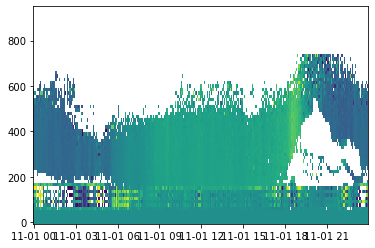

In [5]:
range2D = rango.reshape(v_vertical.T.shape)
plt.pcolormesh(datetime_objects, range2D[0],v_vertical)

### Recolectando la lista de días del año disponibles en el directorio 
## para usar en el modelo de Scherliess-Fejer.

In [6]:
doys = []
frames_avg = []
frames_std = []
PlotFlag=False
plot_format='png'

count=0
intFactor=10
for filename2 in sorted(os.listdir(directory)):
    if filename2.endswith(".h5"):
        doy_temp = float(filename2[14:17])
        range_array,dt,v_vertical = ShowArrays(directory, filename2, PlotFlag)
        #print("Doy %03d: " % doy_temp,filename2 ,range_array.shape, datetime_objects.shape, v_vertical.shape)
        print("Doy: ", doy_temp)
        doys.append(doy)

Doy:  305.0
Doy:  314.0
Doy:  315.0
Doy:  316.0
Doy:  333.0
Doy:  334.0


### Calculando la suma de los arreglos de derivas verticales
### de los archivos del directorio de datos:

jro_drifts2023305.h5
delta_time_array:  300.0
dt_objs:  (288,) (288,)


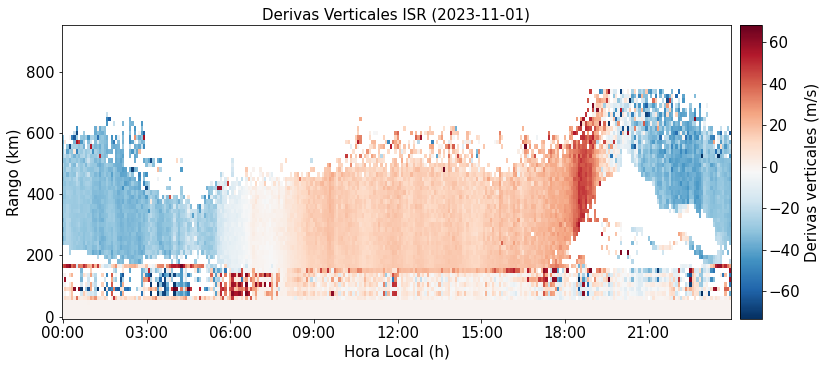

jro_drifts2023314.h5
delta_time_array:  300.0
dt_objs:  (288,) (288,)


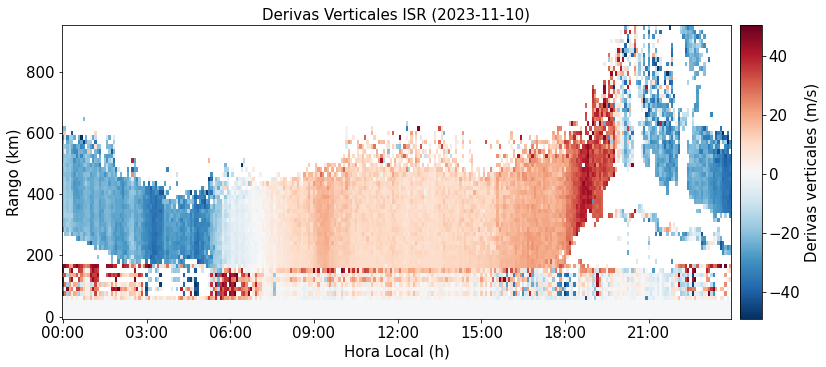

jro_drifts2023315.h5
delta_time_array:  300.0
dt_objs:  (288,) (288,)


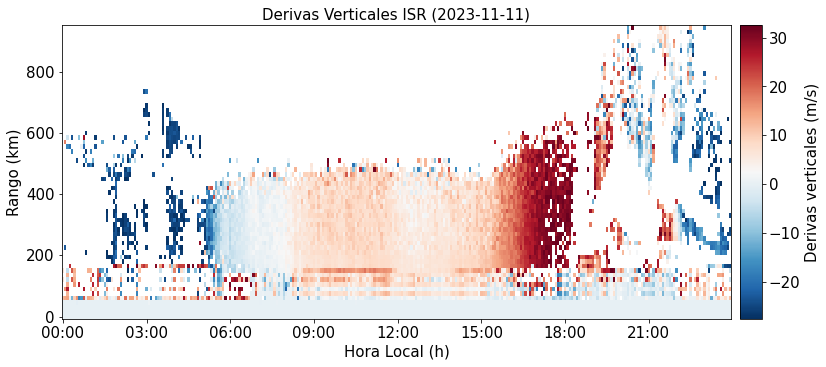

jro_drifts2023316.h5
delta_time_array:  300.0
dt_objs:  (288,) (288,)


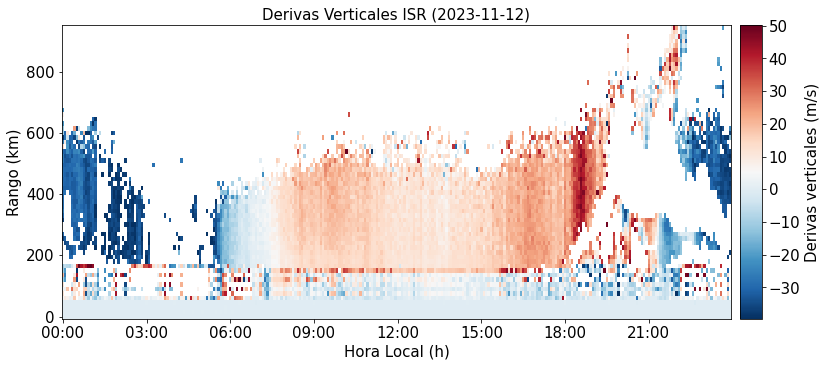

jro_drifts2023333.h5
delta_time_array:  300.0
dt_objs:  (288,) (288,)


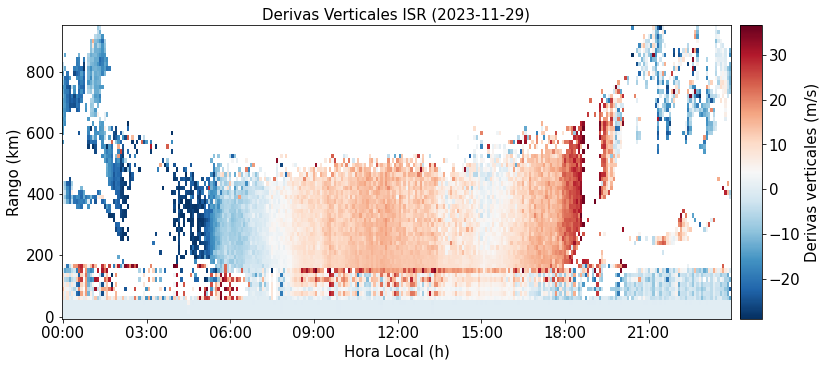

jro_drifts2023334.h5
delta_time_array:  300.0
dt_objs:  (288,) (288,)


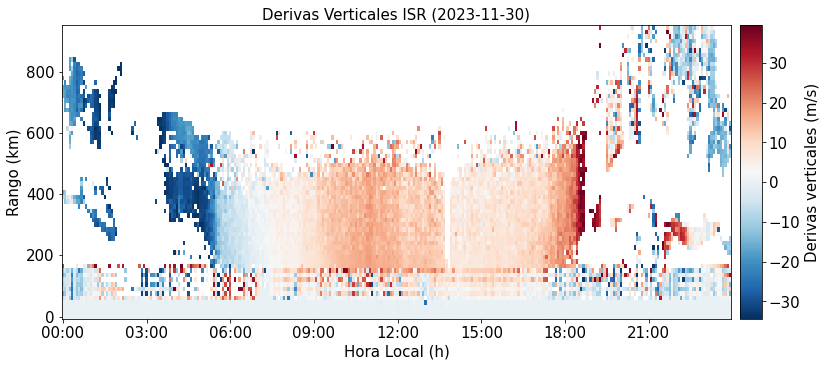

In [7]:
doys = []
frames_avg = []
frames_std = []
PlotFlag=True#False
plot_format='png'

count=0
intFactor=10
promRTI = np.zeros((288,64),dtype='float')
for filename2 in sorted(os.listdir(directory)):
    if filename2.endswith(".h5"):
        print(filename2)
        doy_temp = int(filename2[14:17])
        doys.append(doy_temp)
        v_vert_aux = interp_mat(v_vertical)
        data, range_array, datetime_objects = GetStandardDriftMatrix(directory,filename2, plot_format,PlotFlag)
        #print(data.shape, range_array.shape,datetime_objects.shape)
        promRTI = AddNaN(promRTI,data)#promRTI + v3
        count+=1
        h_min, h_max = 300, 400
        min_ind, max_ind = getRangeIndices(h_min, h_max, range_array)
        str_format = 'png'
        data = v_vert_aux.T[:,:min_ind:max_ind]
        v_vert_avg = np.nanmean(data.T,axis=0)
        v_vert_std = np.nanstd(data.T,axis=0)
        #'''
        df = pd.Series(v_vert_avg, index=datetime_objects)
        df_std = pd.Series(v_vert_std, index=datetime_objects)
        frames_avg.append(df)
        frames_std.append(df_std)
        #'''
    

### Calculando el promedio de los datos de derivas verticales:

In [9]:
avgMat = promRTI/count
avgMat[abs(avgMat)<3 ]=np.nan
avgMat[avgMat<-45]= np.nan
avgMat[avgMat>45]= 40#np.nan
h_min_aux, h_max_aux = 300,400
min_ind_aux, max_ind_aux = getRangeIndices(h_min_aux, h_max_aux, range_array)
prom = np.nanmean(avgMat[:,min_ind:max_ind],axis=1)

/tmp/ipykernel_8418/3579119898.py:7: RuntimeWarning: Mean of empty slice
  prom = np.nanmean(avgMat[:,min_ind:max_ind],axis=1)


### Graficamos el RTI promedio:

Text(0.5, 0.98, 'Promedio mensual de las derivas verticales (Noviembre-2023)')

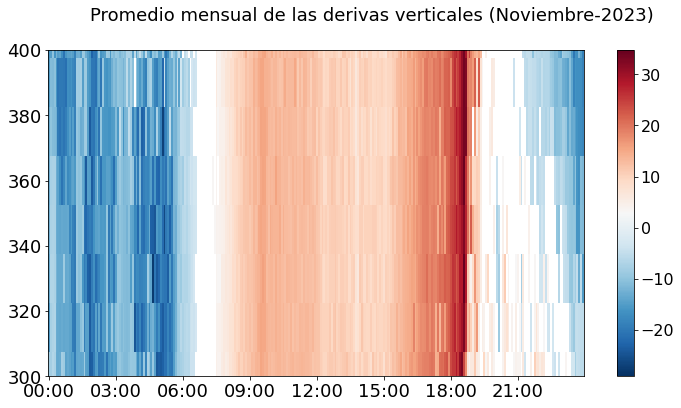

In [10]:
fontsize = 18
fig, ax = plt.subplots(figsize=(12, 6))
clrs = ax.pcolormesh(datetime_objects,range_array,avgMat.T,cmap=plt.cm.RdBu_r)
plt.colorbar(clrs,ax=ax)
ax.xaxis_date()
ax.set_ylim(300,400)
ax.xaxis.set_tick_params(labelsize=fontsize,pad=3)
ax.yaxis.set_tick_params(labelsize=fontsize,pad=3)
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
fig.suptitle('Promedio mensual de las derivas verticales (%s)' % current_month,fontsize=fontsize)

### Calculamos el promedio en alturas: 

/tmp/ipykernel_8418/411494383.py:9: RuntimeWarning: Mean of empty slice
  prom = np.nanmean(avgMat[:,min_ind:max_ind],axis=1)
/usr/lib/python3/dist-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'Promedio de las derivas verticales entre 300 km - 400 km (Noviembre-2023)')

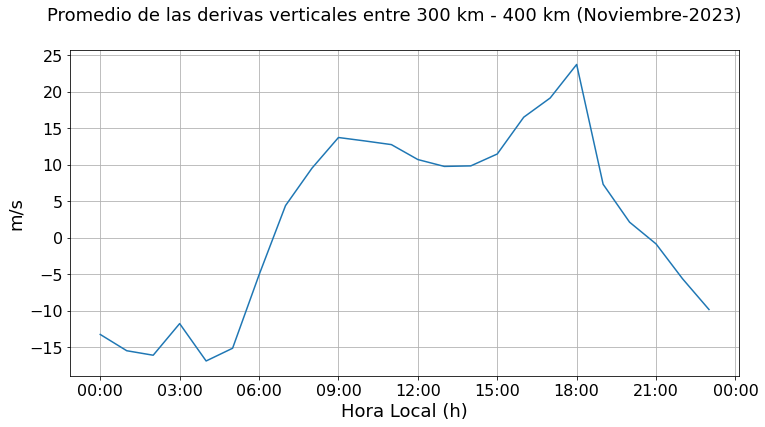

In [11]:
list_avg = []
list_std = []

series_avg = pd.concat(frames_avg)
series_std = pd.concat(frames_std)
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
date_format = mdates.DateFormatter('%H:%M')
prom = np.nanmean(avgMat[:,min_ind:max_ind],axis=1)
dev = np.nanstd(avgMat[:,min_ind:max_ind],axis=1)
df_prom = pd.Series(prom, index=datetime_objects)
df_dev = pd.Series(dev,index=datetime_objects)
fig, axs = plt.subplots(figsize=(12,6))
plt.plot(np.array(df_prom.resample('60min').mean().index),np.array(df_prom.resample('60min').mean()))
list_avg.append(df_prom.resample('1h').mean())#series_avg.groupby(series_avg.index.hour).mean())
list_std.append(df_prom.resample('1h').std())#series_avg.groupby(series_avg.index.hour).std())
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
axs.xaxis.set_major_formatter(date_format)
axs.grid()
fig.suptitle('Promedio de las derivas verticales entre 300 km - 400 km (%s)' % current_month,fontsize=fontsize)

In [12]:
#prom = np.array(series_avg.groupby(series_avg.index.hour).mean())
#std = np.array(series_avg.groupby(series_std.index.hour).std())
#dt = []   

### Estimando las predicciones del modelo de Scherliess-Fejer 
### para los días del año extraídos de los datos:

In [13]:
model_pred = []
str_format = "%Y-%m-%d %H:%M:%S"
modDrifts = []
xtimes = []
for doy in doys:
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    y,xt = drift_model(year,doy,longitude)
    df_v = pd.Series(y, index=xt)
    modDrifts.append(df_v)
    xtimes.append(xt)

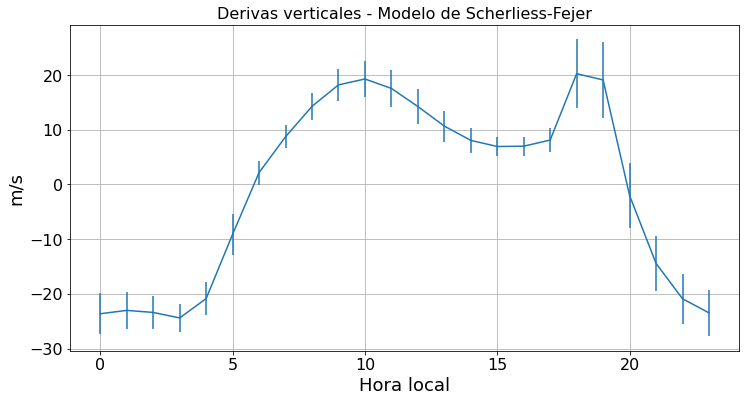

In [14]:
mod_series_avg = pd.concat(modDrifts)
list_avg.append(mod_series_avg.groupby(mod_series_avg.index.hour).mean())
list_std.append(mod_series_avg.groupby(mod_series_avg.index.hour).std())
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=13
plt.rcParams['xtick.labelsize']=13
mod_series_avg.groupby(mod_series_avg.index.hour).mean().plot(yerr=mod_series_avg.groupby(mod_series_avg.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales - Modelo de Scherliess-Fejer' 
axs.set_title(fig_title, fontsize=16)
axs.set_ylabel('m/s',fontsize=18)
axs.set_xlabel('Hora local',fontsize=18)
axs.grid()

In [15]:
mod_series_avg.groupby(mod_series_avg.index.hour).mean()
mod_datetime_obj = mod_series_avg.index
#print(mod_datetime_obj)
mod_avg_array = mod_series_avg.groupby(mod_series_avg.index.hour).mean().values
mod_std_array = mod_series_avg.groupby(mod_series_avg.index.hour).std().values

In [17]:
avgData = np.nanmean(medfilt2d(avgMat.T),axis=0)
dt1 = datetime.datetime(datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,0,0,0)#time_objects_avg[0]
dt2 = dt1 + datetime.timedelta(hours=23, minutes=55)
print(dt1,dt2)

2023-11-30 00:00:00 2023-11-30 23:55:00


In [20]:
plots_boletines = '/home/jp/Desktop-ROJ/Plots-Boletines/%d/%s' % (year , str_month)
datetime_objects = np.array(datetime_objects,dtype='datetime64')
print(plots_boletines)

/home/jp/Desktop-ROJ/Plots-Boletines/2023/Noviembre


In [21]:
avgMat_final =  avgMat.copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(288,) <class 'numpy.ndarray'> <class 'datetime.timedelta'>


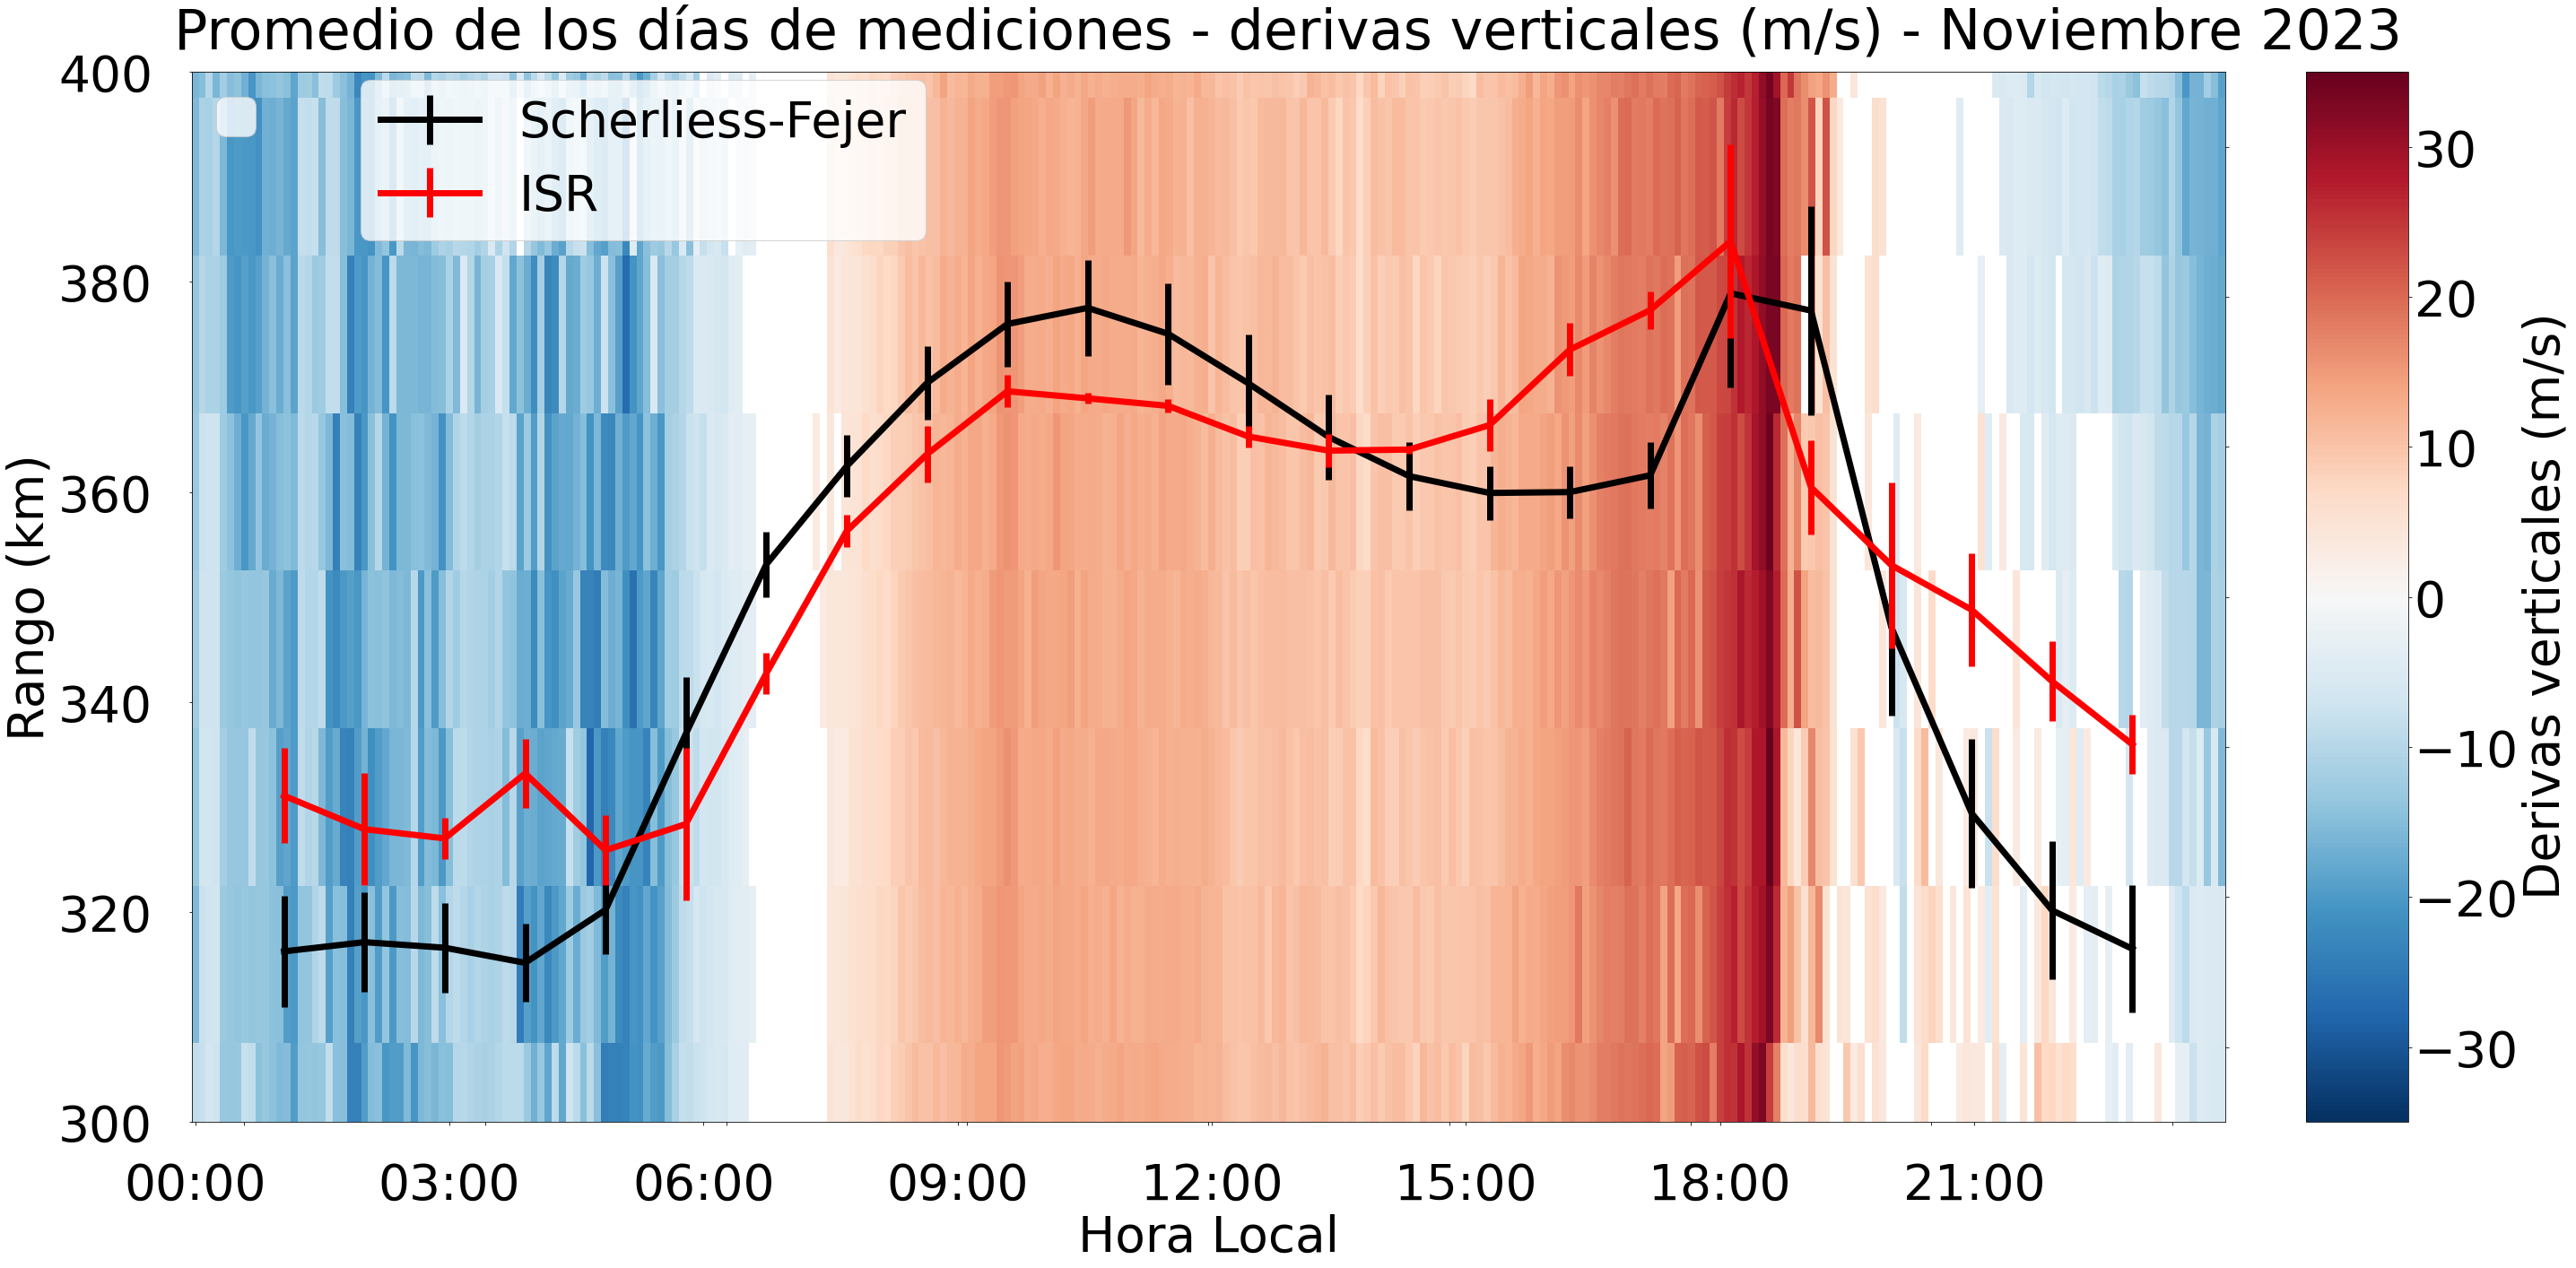

In [24]:
fontsize=55
cb_down = -35#-35#-35#15
cb_up = 35#35#35
plot_format = 'pdf'

fig = plt.figure(figsize=(40,20),tight_layout=True)
plt.rcParams['ytick.labelsize']=35
plt.rcParams['xtick.labelsize']=35
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax3=fig.add_subplot(111, label="3", frame_on=False)
fig.suptitle("Promedio de los días de mediciones - derivas verticales (m/s) - %s %d" % (GetMonth(month),year) ,fontsize=fontsize+7)
color_palette='jet'#'seismic'#'seismic_r'#'jet'#'RdBu_r'#'plasma'
#range_array, datetime_objects
ax.plt= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, avgMat_final.T, cmap=plt.cm.RdBu_r)#ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)
color='red'
ax.set_xlabel('Hora Local',fontsize=fontsize)
ax.set_ylabel('Rango (km)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize,pad=40)
ax.set_ylim(h_min, h_max)
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
color_aux='white'
width_aux=6
cax = ax.inset_axes([1.04, 0, 0.05, 1])
cbar=fig.colorbar(ax.plt,ax=ax,cax=cax)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.mappable.set_clim(cb_down,cb_up)
print(datetime_objects.shape, type(datetime_objects),type(datetime.timedelta(hours=0.5)))
ax2.plt = ax2.errorbar(list_avg[0].index+ datetime.timedelta(hours=0.5), list_avg[1], yerr=list_std[1], label='Scherliess-Fejer',marker='o',color='black',lw=7)
ax2.xaxis_date()
plt.legend(loc="upper left",prop={'size':fontsize})
ax2.axes.yaxis.set_ticklabels([])
#ax2.axes.yaxis.set_visible(False)
nan_series={}
ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylim(cb_down, cb_up)

ax3.plt = ax3.errorbar(list_avg[0].index+datetime.timedelta(hours=0.5), list_avg[0], yerr=list_std[0], label='ISR',marker='o',color='red',lw=7)
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(date_format)
ax3.axes.xaxis.set_ticklabels([])
ax3.yaxis.tick_right()
ax3.set_ylim(cb_down, cb_up)
ax3.axes.yaxis.set_visible(False)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
plot_format='pdf'
fig.legend(loc = (0.14, 0.81), ncol=1, borderaxespad=10, fontsize=fontsize)
plt_dir = 'Plots-%s' % current_month
plt.savefig('%s/drifts-isr-julia-%s-%d.%s' % (plots_boletines,str_month.lower(),year,plot_format))

In [25]:
doys

[305, 314, 315, 316, 333, 334]

(24,) (24,)


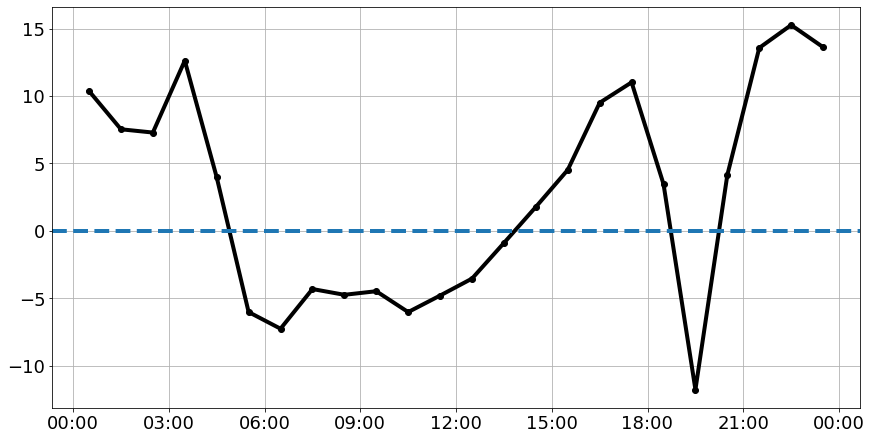

In [26]:
vertical_residuals = np.array(list_avg[0]) - np.array(list_avg[1])
vertical_percentage = 100*vertical_residuals/(np.array(list_avg[1]))
t = np.array(list_avg[0].index+timedelta(hours=0.5))
print(vertical_residuals.shape,t.shape)
fontsize=18
fig,ax = plt.subplots(figsize=(12,6),constrained_layout=True)
#ax.plot(np.array(list_avg[0].index+datetime.timedelta(hours=0.5)), np.array(list_avg[0]), label='ISR',marker='o',color='red',lw=7)
ax.plot(t, vertical_residuals,marker='o',color='black',lw=4)
#ax.plot(t, vertical_percentage,marker='o',color='black',lw=4)
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.axhline(0,linestyle='dashed',lw=4)
ax.grid()

In [28]:
model_prom = mod_series_avg.groupby(mod_series_avg.index.hour).mean()
model_err = mod_series_avg.groupby(mod_series_avg.index.hour).std()
model_ind =  mod_series_avg.groupby(mod_series_avg.index.hour).mean().index
model_index = np.array([datetime.datetime(year,month,datetime_objects[0].astype(object).day,h,30,0) for h in model_ind])
prom_index = np.array([datetime.datetime(year,month,datetime_objects[0].astype(object).day,h,30,0) for h in df_prom.groupby(df_prom.index.hour).mean().index])#.to_numpy()#[:, None]
hourly_prom = np.array(df_prom.groupby(df_prom.index.hour).mean())
hourly_err = np.array(df_prom.groupby(df_prom.index.hour).std())
res_max = np.max(vertical_residuals)
ind_res_max = np.where(vertical_residuals==res_max)
res_min = np.min(vertical_residuals)
ind_res_min = np.where(vertical_residuals==res_min)
print(prom_index[ind_res_max],np.array(model_prom)[ind_res_max],hourly_prom[ind_res_max])
print(prom_index[ind_res_min],np.array(model_prom)[ind_res_min],hourly_prom[ind_res_min])


[datetime.datetime(2023, 11, 30, 22, 30)] [-20.8845029] [-5.62032407]
[datetime.datetime(2023, 11, 30, 19, 30)] [19.09233667] [7.31478505]


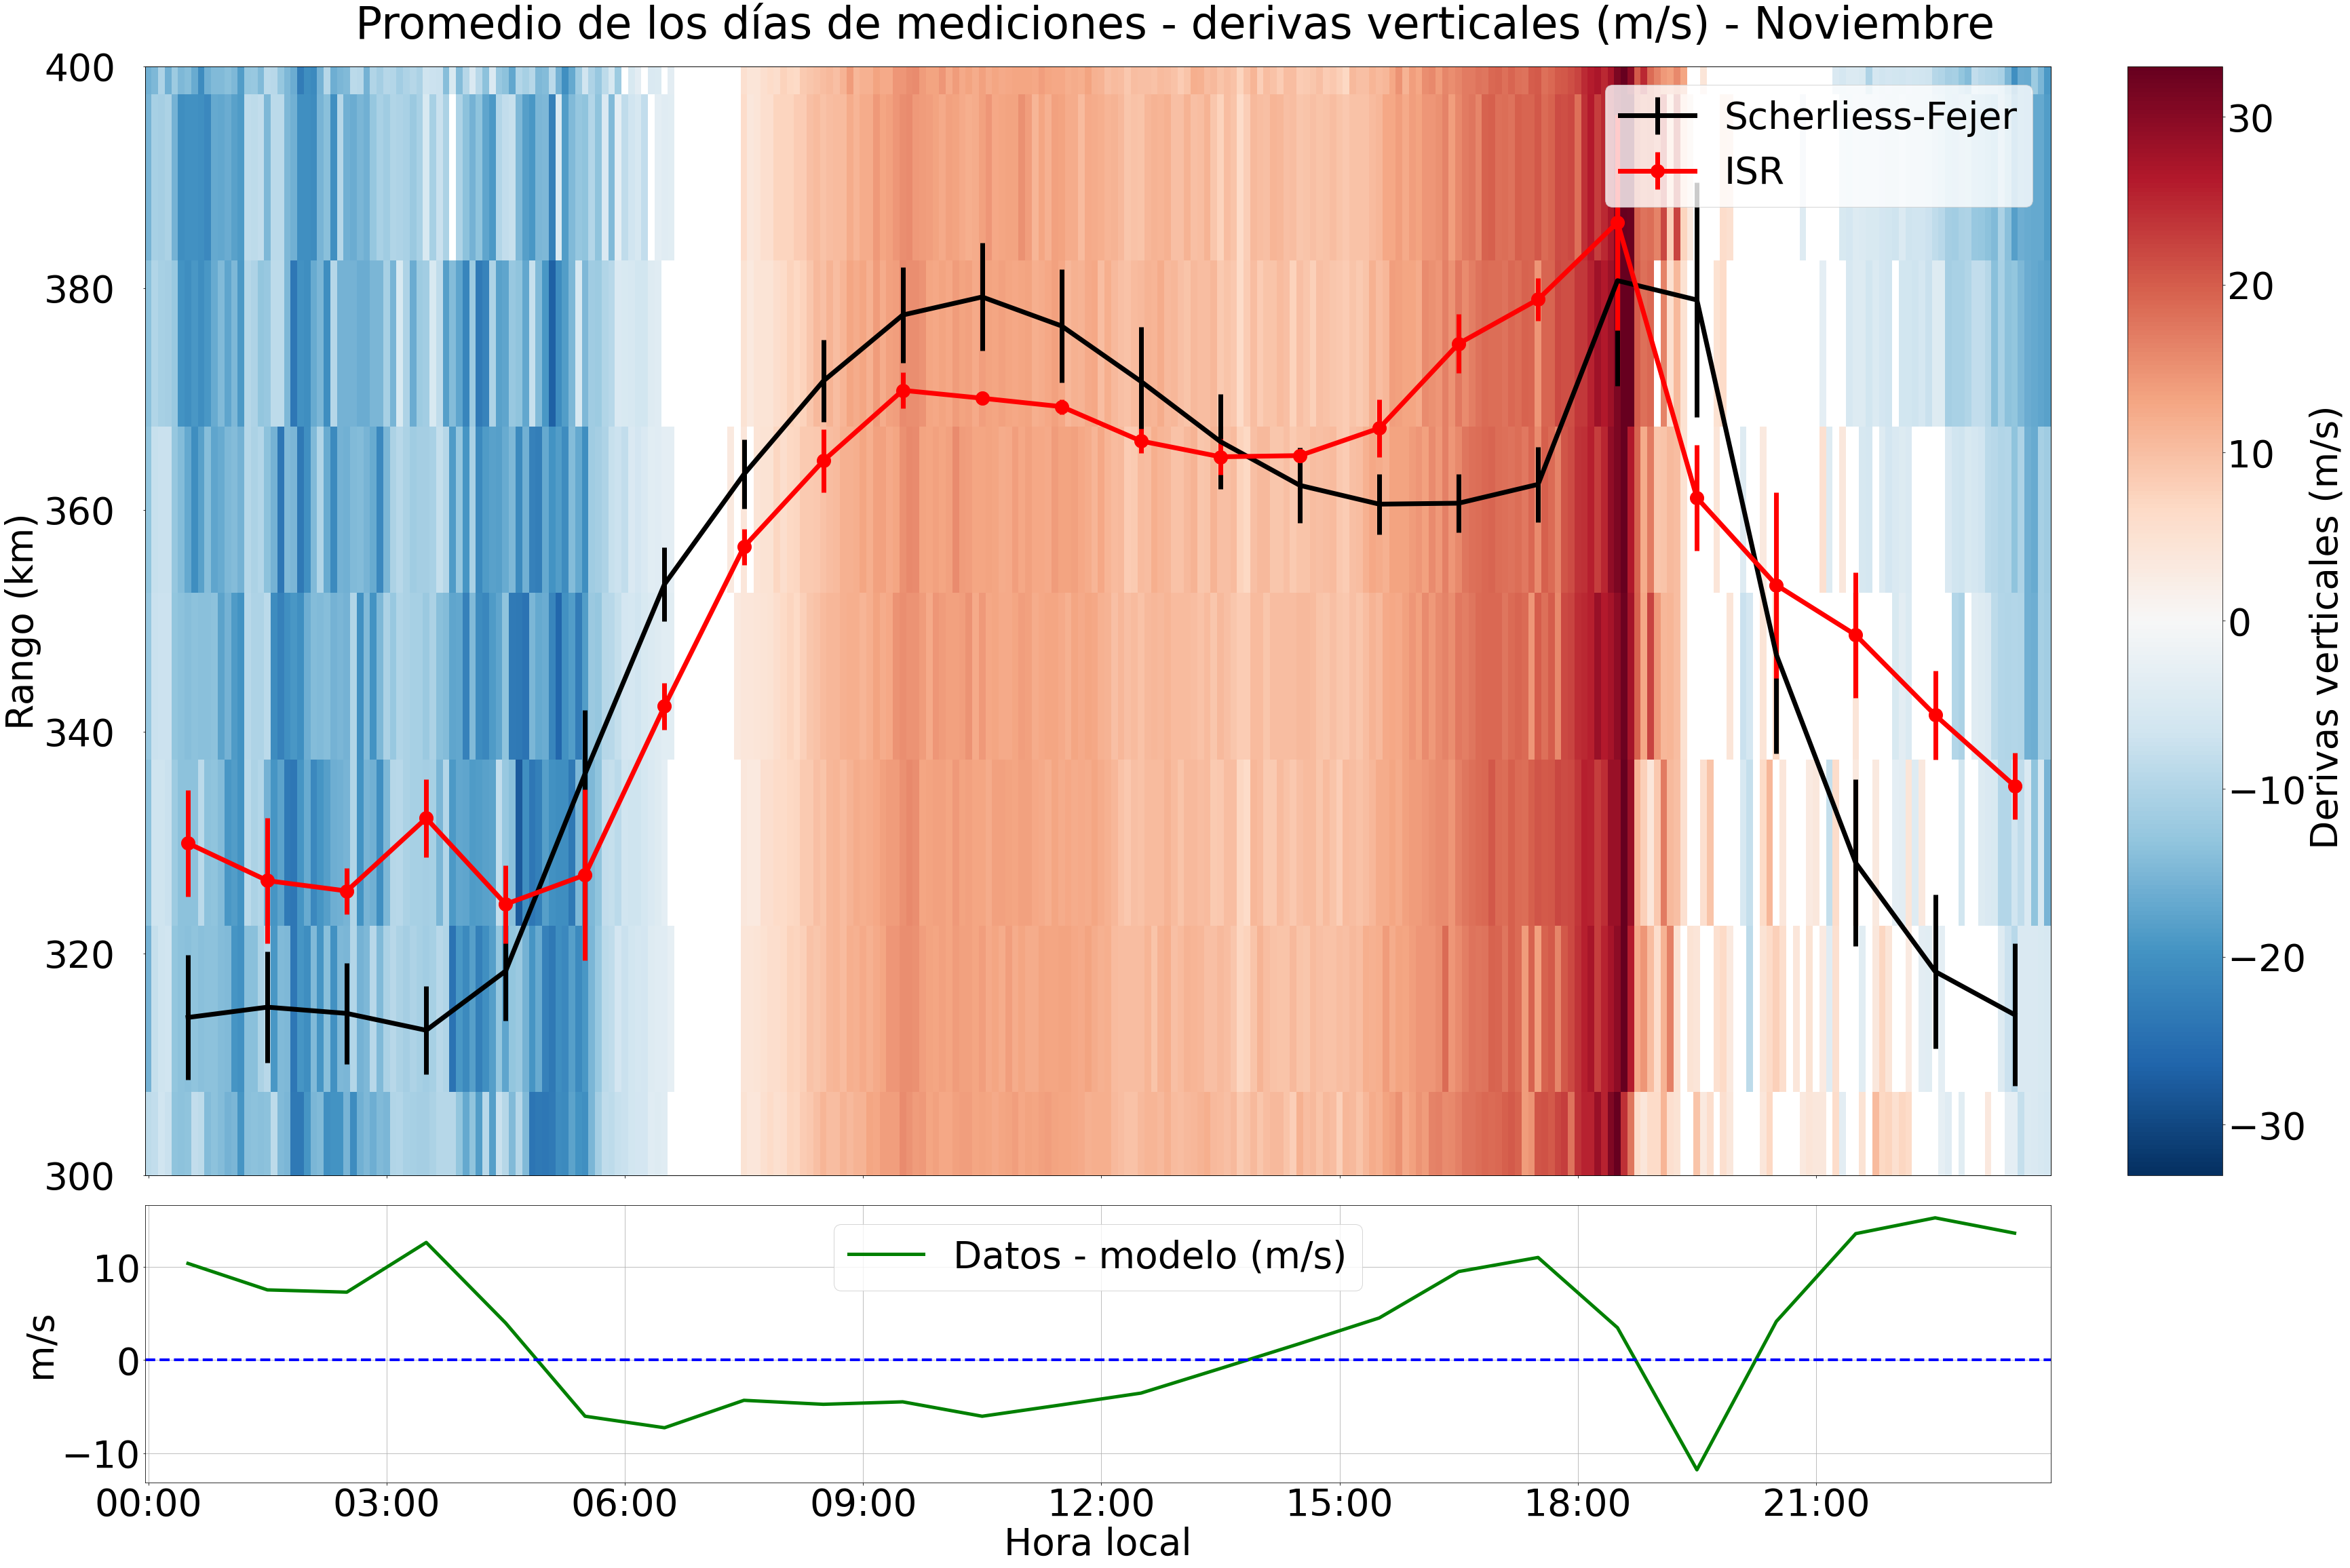

In [29]:
gridspec_kw = dict(height_ratios=(4, 1),hspace=0.01,)
fontsize=55
cb_down = -33#-35#15
cb_up = 33#35
plot_format = 'pdf'
fig,ax = plt.subplots(nrows=2,ncols=1,constrained_layout=True,sharex=True,gridspec_kw=gridspec_kw,figsize=(48,32))
fig.suptitle("Promedio de los días de mediciones - derivas verticales (m/s) - %s" % GetMonth(month) ,fontsize=fontsize+10)
color_palette='jet'#'seismic'#'seismic_r'#'jet'#'RdBu_r'#'plasma'
clrs1 = ax[0].pcolormesh(mdates.date2num(datetime_objects), range_array, avgMat_final.T, cmap=plt.cm.RdBu_r)#ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)
color='red'
ax[0].set_ylabel('Rango (km)',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize,pad=40)
ax[0].set_ylim(h_min, h_max)
ax[0].xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(date_format)
color_aux='white'
width_aux=6
#ax[0].set_xlim(dt1, dt2)
cax = ax[0].inset_axes([1.04, 0, 0.05, 1])
cbar=fig.colorbar(clrs1,ax=ax[0],cax=cax)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.mappable.set_clim(cb_down,cb_up)
ax2 = ax[0].twinx()
ax2.errorbar(model_index, model_prom, yerr=model_err, label='Scherliess-Fejer',marker='o',color='black',lw=7)
ax2.legend(loc="upper left",prop={'size':fontsize})
ax2.axes.yaxis.set_ticklabels([])
ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylim(cb_down, cb_up)
#ax2.set_xlim(dt1, dt2)
ax2.errorbar(prom_index, hourly_prom,yerr=hourly_err,label='ISR',marker='o',color='red',lw=7, markersize=20)
ax2.axes.xaxis.set_ticklabels([])
ax2.yaxis.tick_right()
#ax2.set_xlim(dt1, dt2)
ax2.set_ylim(cb_down, cb_up)
ax2.axes.yaxis.set_visible(False)
ax2.grid()
ax2.legend(fontsize=fontsize)
#cbar2.mappable.set_clim(-20,20)
plot_format='pdf'
ax[1].plot(np.array(prom_index),vertical_residuals, label='Datos - modelo (m/s)',lw=5,color='green')
ax[1].axhline(0,linestyle='dashed',color='blue',lw=4)
ax[1].xaxis_date()
ax[1].xaxis.set_major_formatter(date_format)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)
ax[1].grid()
ax[1].set_xlabel('Hora local', fontsize=fontsize)
ax[1].set_ylabel('m/s',fontsize=fontsize)
ax[1].legend(fontsize=fontsize)
plot_format='pdf'
plt.savefig('%s/drifts-isr-julia-%s-%d.%s' % (plots_boletines,str_month.lower(),year,plot_format))
#plt.show()

In [30]:
max_data = np.max(hourly_prom)
min_data = np.min(hourly_prom)
max_model = np.max(model_prom)
min_model = np.min(model_prom)
max_res = np.max(vertical_residuals)
ind_max_data = np.where(hourly_prom==max_data)[0][0]
time_max_data = prom_index[ind_max_data]
ind_min_data = np.where(hourly_prom==min_data)[0][0]
time_min_data = prom_index[ind_min_data]

ind_max_model = np.where(model_prom==max_model)[0][0]
time_max_model = model_index[ind_max_model]
ind_min_model = np.where(model_prom==min_model)[0][0]
time_min_model = model_index[ind_min_model]

ind_max_res = np.where(vertical_residuals==max_res)[0][0]
time_max_res = model_index[ind_max_res]
print("Data max.: ", round(max_data,1)," m/s (%s)" % time_max_data.strftime("%H:%M:%S"))#, ")")
print("Data min.: ", round(min_data,1)," m/s (%s)" %  time_min_data.strftime("%H:%M:%S")) 
print("Model max.: ", round(max_model,1)," m/s (%s)"% time_max_model.strftime("%H:%M:%S"))
print("Model min.: ", round(min_model,1)," m/s (%s)"% time_min_model.strftime("%H:%M:%S")) 
print("Discrepancia max.: ",round(max_res,1)," m/s (%s)"% time_max_res.strftime("%H:%M:%S"))
print("Discrepancia promedio: ",np.nanmean(vertical_residuals), np.nanmean(vertical_percentage))

Data max.:  23.7  m/s (18:30:00)
Data min.:  -16.9  m/s (04:30:00)
Model max.:  20.2  m/s (18:30:00)
Model min.:  -24.4  m/s (03:30:00)
Discrepancia max.:  15.3  m/s (22:30:00)
Discrepancia promedio:  2.698268675887848 -31.7741060056287


In [31]:
res_max = np.max(vertical_residuals)
ind_res_max = np.where(vertical_residuals==res_max)[0][0]
res_min = np.min(vertical_residuals)
ind_res_min = np.where(vertical_residuals==res_min)[0][0]
print(res_max,vertical_residuals[ind_res_max],t[ind_res_max])
print(res_min,vertical_residuals[ind_res_min],t[ind_res_min])

15.264178829571144 15.264178829571144 2023-11-30T22:30:00.000000000
-11.777551612271896 -11.777551612271896 2023-11-30T19:30:00.000000000


In [32]:
mod_max = np.max(list_avg[1])
ind_mod_max = np.where(list_avg[1]==mod_max)[0][0]
mod_min = np.min(list_avg[1])
ind_mod_min = np.where(list_avg[1]==mod_min)[0][0]
print(mod_max,list_avg[1][ind_mod_max],t[ind_mod_max])
print(mod_min,list_avg[1][ind_mod_min],t[ind_mod_min])

20.243238115247255 20.243238115247255 2023-11-30T18:30:00.000000000
-24.3827154983331 -24.3827154983331 2023-11-30T03:30:00.000000000


In [33]:
dat_max = np.max(list_avg[0])
ind_dat_max = np.where(list_avg[0]==dat_max)[0][0]
dat_min = np.min(list_avg[0])
ind_dat_min = np.where(list_avg[0]==dat_min)[0][0]
print(dat_max,list_avg[0][ind_dat_max],t[ind_dat_max])
print(dat_min,list_avg[0][ind_dat_min],t[ind_dat_min])

23.712738095238095 23.712738095238095 2023-11-30T18:30:00.000000000
-16.877539682539684 -16.877539682539684 2023-11-30T04:30:00.000000000
